# Cell 1: Import Libraries
- **Purpose**: Import necessary Python libraries for data processing, machine learning, natural language processing, and logging.
- **Inputs**: None.
- **Outputs**: None (sets up the environment).
- **Operations**:
  - Imports libraries such as `pandas`, `numpy`, `sklearn`, `nltk`, `vaderSentiment`, `matplotlib`, `seaborn`, `logging`, `tqdm`, `pickle`, and `os`.
  - Ensures all dependencies are available for subsequent cells.
- **Note**: The libraries cover data manipulation, text processing, model training, and evaluation metrics.

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, hamming_loss, precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import SelectPercentile, chi2
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, download
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from tqdm import tqdm
import pickle
import os
from datetime import datetime

# Cell 2: Set Up Logging
- **Purpose**: Configure logging to track the execution process and debug issues.
- **Inputs**: None.
- **Outputs**: Configured `logging` module with INFO level.
- **Operations**:
  - Sets logging level to INFO with a custom format including timestamp, level, and message.
  - Creates a logger object (`logger`) for use in subsequent cells.
- **Note**: Logging helps monitor the pipeline's progress and identify errors during execution.

In [75]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Cell 3: Define NLTK Resource Download Function
- **Purpose**: Define a function to download required NLTK resources with error handling.
- **Inputs**: None.
- **Outputs**: None (defines the function `download_nltk_resources`).
- **Operations**:
  - Defines a list of NLTK resources: `punkt`, `stopwords`, `wordnet`, `averaged_perceptron_tagger`.
  - Iterates over resources and downloads them using `nltk.download` with quiet mode.
  - Logs errors and raises exceptions if downloads fail.
- **Note**: This function ensures NLTK dependencies are available for text processing.

In [76]:

# Download NLTK resources with error handling
def download_nltk_resources():
    resources = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']
    for resource in resources:
        try:
            download(resource, quiet=True)
        except Exception as e:
            logger.error(f"Failed to download NLTK resource {resource}: {e}")
            raise

# Cell 4: Download NLTK Resources
- **Purpose**: Execute the `download_nltk_resources` function to download NLTK resources.
- **Inputs**: None.
- **Outputs**: Downloaded NLTK resources.
- **Operations**:
  - Calls `download_nltk_resources()`.
- **Note**: Ensures resources are available before text preprocessing.

In [77]:
# Code for Cell 4: Call download_nltk_resources()

download_nltk_resources()

# Cell 5: Define Custom Stopwords
- **Purpose**: Create a custom stopword list tailored for movie summaries.
- **Inputs**: NLTK's default English stopwords.
- **Outputs**: `custom_stopwords` set.
- **Operations**:
  - Starts with NLTK's English stopwords.
  - Removes sentiment-carrying words (`no`, `not`, `nor`, etc.) to preserve meaning.
  - Adds movie-specific stopwords (`movie`, `film`, `story`, etc.) to reduce noise.
- **Note**: The custom stopwords balance noise reduction with sentiment preservation.

In [78]:
# Code for Cell 5: Define custom_stopwords


# Custom stopwords
custom_stopwords = set(stopwords.words('english')) - {'no', 'not', 'nor', 'none', 'never', 'neither', 'barely', 'hardly', 'rarely', 'seldom'}
custom_stopwords.update({'movie', 'film', 'story', 'plot', 'scene', 'character', 'directed', 'director'})


# Cell 6: Initialize Preprocessing Tools
- **Purpose**: Initialize NLTK's lemmatizer and VADER sentiment analyzer.
- **Inputs**: None.
- **Outputs**: `lemmatizer` and `sentiment_analyzer` objects.
- **Operations**:
  - Creates a `WordNetLemmatizer` instance for lemmatization.
  - Creates a `SentimentIntensityAnalyzer` instance for sentiment analysis.
- **Note**: These tools are used for text preprocessing and feature extraction.

In [79]:
# Code for Cell 6: Initialize lemmatizer and sentiment_analyzer


# Initialize lemmatizer and sentiment analyzer
lemmatizer = WordNetLemmatizer()
sentiment_analyzer = SentimentIntensityAnalyzer()

# Cell 7: Create Models Directory
- **Purpose**: Create a directory to store trained models and related files.
- **Inputs**: None.
- **Outputs**: `./models` directory.
- **Operations**:
  - Uses `os.makedirs` to create the `./models` directory, with `exist_ok=True` to avoid errors if it already exists.
- **Note**: Ensures a dedicated location for saving model artifacts.

In [80]:
# Code for Cell 7: Create ./models directory


# Create models directory
os.makedirs('./models', exist_ok=True)

# Cell 8: Load and Merge Datasets
- **Purpose**: Load movie metadata and summaries, then merge them into a single dataset.
- **Inputs**: `movie.metadata.tsv`, `plot_summaries.txt`.
- **Outputs**: Merged `data` DataFrame with shape (42204, 10).
- **Operations**:
  - loads `movie.metadata.tsv` into `metadata` with columns like `wiki_id`, `title`, `genres`.
  - Loads `plot_summaries.txt` into `summaries` with `wiki_id` and `summary`.
  - Merges on `wiki_id` using an inner join.
  - Logs the dataset shape.
  - Displays the first five rows.
- **Note**: The merge ensures only movies with both metadata and summaries are included.

In [81]:
# Code for Cell 8: Load and merge datasets
# Load and merge datasets
logger.info("Loading datasets...")
metadata = pd.read_csv('./MovieSummaries/movie.metadata.tsv', sep='\t', header=None,
                       names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'])
summaries = pd.read_csv('./MovieSummaries/plot_summaries.txt', sep='\t', header=None,
                        names=['wiki_id', 'summary'])
data = pd.merge(metadata, summaries, on='wiki_id', how='inner')
logger.info(f"Dataset merged. Shape: {data.shape}")
data.head()

2025-05-12 15:41:29,763 - INFO - Loading datasets...
2025-05-12 15:41:30,640 - INFO - Dataset merged. Shape: (42204, 10)


,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


# Cell 9: Drop Irrelevant Columns
- **Purpose**: Reduce the dataset to relevant columns for genre prediction.
- **Inputs**: Merged `data` DataFrame.
- **Outputs**: `data` DataFrame with columns `wiki_id`, `genres`, `summary`.
- **Operations**:
  - Drops columns: `title`, `freebase_id`, `release_date`, `revenue`, `runtime`, `languages`, `countries`.
  - Displays the first five rows.
- **Note**: Focuses the dataset on data needed for genre prediction.

In [82]:
# Code for Cell 9: Drop irrelevant columns

# delete columns
data.drop(columns=['title','freebase_id', 'release_date', 'revenue', 'runtime', 'languages', 'countries'], inplace=True)
data.head(5)

,wiki_id,genres,summary
0,975900,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


# Cell 10: Define Genre Parsing Function
- **Purpose**: Define a function to parse genres from JSON-like strings.
- **Inputs**: Genre string (e.g., `{"/m/01jfsb": "Thriller", ...}`).
- **Outputs**: List of genre names.
- **Operations**:
  - Handles empty or null inputs by returning an empty list.
  - Uses regex (`re.findall(r'"([^"]+)"', genre_str)[1::2]`) to extract genre names.
- **Note**: Ensures robust parsing of complex genre metadata.

In [83]:
# Code for Cell 10: Define parse_genres function

# Parse genres
def parse_genres(genre_str):
    if pd.isna(genre_str) or genre_str == '{}':
        return []
    return re.findall(r'"([^"]+)"', genre_str)[1::2]

# Cell 11: Apply Genre Parsing
- **Purpose**: Parse genres for all movies in the dataset.
- **Inputs**: `data` DataFrame with `genres` column.
- **Outputs**: `data` DataFrame with `genres` as lists of genre names.
- **Operations**:
  - Applies `parse_genres` to the `genres` column.
  - Displays the first five rows.
- **Note**: Converts raw genre strings into usable lists for multi-label classification.

In [84]:
# Code for Cell 11: Apply parse_genres


data['genres'] = data['genres'].apply(parse_genres)
print(data.head(20))


     wiki_id                                             genres  \
0     975900  [Thriller, Science Fiction, Horror, Adventure,...   
1    9363483  [Thriller, Erotic thriller, Psychological thri...   
2     261236                                            [Drama]   
3   18998739    [Family Film, Fantasy, Adventure, World cinema]   
4    6631279  [Romantic comedy, Ensemble Film, Comedy-drama,...   
5     171005  [Costume drama, War film, Epic, Period piece, ...   
6   18296435                                           [Comedy]   
7   11250635  [Science Fiction, Adventure, Animation, Short ...   
8      77856  [Children's/Family, Musical, Fantasy, Comedy, ...   
9   32456683                                                 []   
10  21926710     [Romantic comedy, Romance Film, Comedy, Indie]   
11  20604092                                     [Romance Film]   
12    156558              [Crime Fiction, Drama, Coming of age]   
13  11448183                              [Family Film, Comedy

# Cell 12: Define Genre Mapping
- **Purpose**: Define a mapping to consolidate similar genres into broader categories.
- **Inputs**: None.
- **Outputs**: `genre_mapping` dictionary.
- **Operations**:
  - Maps specific genres (e.g., `Action Comedy` to `Action`, `Anime` to `Animation`).
  - Groups genres into categories like Action, Comedy, Drama, etc., to reduce noise.
- **Note**: Simplifies the genre set for better model performance.

In [85]:
# Code for Cell 12: Define genre_mapping

genre_mapping = {
    # Action category
    'Action Comedy': 'Action',
    'Action Thrillers': 'Action',
    'Action/Adventure': 'Action',
    'Martial Arts Film': 'Action',
    'Spy': 'Action',
    'Spy film': 'Action',
    'Superhero movie': 'Action',
    
    # Adventure category
    'Family-Oriented Adventure': 'Adventure',
    'Fantasy Adventure': 'Adventure',
    'Western': 'Adventure',
    
    # Animation category
    'Anime': 'Animation',
    'Computer Animation': 'Animation', 
    'Stop motion': 'Animation',
    "Children's": 'Animation',
    
    # Comedy category
    'Adventure Comedy': 'Comedy',
    'Black comedy': 'Comedy',
    'Comedy Thriller': 'Comedy',
    'Comedy film': 'Comedy',
    'Comedy horror': 'Comedy',
    'Comedy of Errors': 'Comedy',
    'Comedy of manners': 'Comedy',
    'Comedy-drama': 'Comedy',
    'Crime Comedy': 'Comedy',
    'Domestic Comedy': 'Comedy',
    'Fantasy Comedy': 'Comedy',
    'Horror Comedy': 'Comedy',
    'Musical comedy': 'Comedy',
    'Parody': 'Comedy',
    'Romantic comedy': 'Comedy',
    'Satire': 'Comedy',
    'Screwball comedy': 'Comedy',
    'Sex comedy': 'Comedy',
    'Slapstick': 'Comedy',
    
    # Drama category
    'Addiction Drama': 'Drama',
    'Biographical film': 'Drama',
    'Biography': 'Drama',
    'Biopic [feature]': 'Drama',
    'Courtroom Drama': 'Drama',
    'Crime Drama': 'Drama',
    'Family Drama': 'Drama',
    'Legal drama': 'Drama',
    'Medical drama': 'Drama',
    'Melodrama': 'Drama',
    'Political cinema': 'Drama',
    'Political drama': 'Drama',
    'Romantic drama': 'Drama',
    'War film': 'Drama',
    
    # Documentary category
    'Culture & Society': 'Documentary',
    'Docudrama': 'Documentary',
    'History': 'Documentary',
    'Mockumentary': 'Documentary',
    'Social guidance film': 'Documentary',
    
    # Horror category
    'Creature Film': 'Horror',
    'Gothic Film': 'Horror',
    'Monster movie': 'Horror',
    'Natural horror films': 'Horror',
    'Slasher': 'Horror',
    'Supernatural': 'Horror',
    'Zombie Film': 'Horror',
    
    # Thriller category
    'Crime Thriller': 'Thriller',
    'Erotic thriller': 'Thriller',
    'Political thriller': 'Thriller',
    'Psychological thriller': 'Thriller',
    'Suspense': 'Thriller',
    
    # Science Fiction category
    'Dystopian': 'Sci-Fi',
    'Science Fiction': 'Sci-Fi',
    'Space western': 'Sci-Fi',
    
    # Fantasy category
    "Children's Fantasy": 'Fantasy',
    
    # Film types/styles
    'Art film': 'Indie',
    'B-movie': 'Cult',
    'Black-and-white': 'Classic',
    'Film noir': 'Classic',
    'Silent film': 'Classic',
    
    # Regional cinema
    'Bollywood': 'World cinema',
    'Chinese Movies': 'World cinema',
    'Filipino Movies': 'World cinema',
    'Japanese Movies': 'World cinema',
    
    # LGBTQ+ categories
    'Gay': 'LGBT',
    'Gay Interest': 'LGBT',
    'Gay Themed': 'LGBT',
    
    # Other specific genres
    'Coming of age': 'Drama',
    'Costume drama': 'Period piece',
    'Crime Fiction': 'Crime Drama',
    'Detective': 'Mystery',
    'Detective fiction': 'Mystery',
    'Disaster': 'Action',
    'Ensemble Film': 'Drama',
    'Epic': 'Adventure',
    'Erotica': 'Adult',
    'Family Film': 'Family',
    'Film adaptation': 'Drama',
    'Gangster Film': 'Crime Drama',
    'Historical fiction': 'Period piece',
    'Music': 'Musical',
    'Road movie': 'Adventure',
    'Romance Film': 'Romance',
    'Short Film': 'Short Film',
    'Sports': 'Sports',
    'Teen': 'Coming of age',
    'Television movie': 'TV Movie'
}

# Cell 13: Standardize Genres and Filter Data
- **Purpose**: Standardize genres, remove empty genres, and filter out rows with empty summaries.
- **Inputs**: `data` DataFrame, `genre_mapping`, `logger`.
- **Outputs**: Updated `data` DataFrame with standardized genres and filtered rows.
- **Operations**:
  - Logs the initial number of lines in `data`.
  - Maps genres in the `genres` column to standardized values using `genre_mapping`, retaining unmapped genres as-is.
  - Filters out rows with empty `genres` lists.
  - Filters out rows with missing or empty `summary` values.
  - Logs the final number of lines in `data`.
- **Note**: Ensures data quality by removing invalid entries and maintaining consistent genre labels.


In [86]:
# Code for Cell 13: Apply genre mapping

logger.info(f"Number of lines in data: {len(data)}")

data['genres'] = data['genres'].apply(lambda genres: list(set(tuple(genre_mapping.get(g, g)) for g in genres if isinstance(g, str))))
#filer out empty genres
data = data[data['genres'].map(len) > 0]
# Filter out rows with empty summaries
data = data[data['summary'].notna() & (data['summary'] != '')]


logger.info(f"Number of lines in data: {len(data)}")


2025-05-12 15:41:30,980 - INFO - Number of lines in data: 42204
2025-05-12 15:41:31,111 - INFO - Number of lines in data: 41793


# Cell 14: Filter Rare Genres and Compute Genre Correlations
- **Purpose**: Remove rare genres, create a genre matrix, and compute correlations between genres.
- **Inputs**: `data` DataFrame, `logger`, `Counter`, `np` (NumPy), `pd` (Pandas).
- **Outputs**: Updated `data` DataFrame with filtered genres, `genre_matrix`, `genre_correlations` DataFrame.
- **Operations**:
  - Counts occurrences of each genre across all rows using `Counter`.
  - Identifies common genres with at least 100 occurrences.
  - Filters `genres` column to retain only common genres.
  - Logs the number of unique common genres.
  - Creates a binary `genre_matrix` where rows are data entries and columns are common genres (1 if genre is present, 0 otherwise).
  - Maps genres to matrix indices using `genre_to_idx`.
  - Computes a correlation matrix (`genre_correlations`) between genres using the transposed `genre_matrix`.
- **Note**: Reduces dataset noise by removing rare genres and provides insights into genre relationships via correlations.

In [87]:
# Filter rare genres
genre_counts = Counter(genre for genres in data['genres'] for genre in genres)
common_genres = {genre for genre, count in genre_counts.items() if count >= 100}
data['genres'] = data['genres'].apply(lambda genres: [g for g in genres if g in common_genres])
logger.info(f"Unique genres: {len(common_genres)}")

genre_matrix = np.zeros((len(data), len(common_genres)))
genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(common_genres))}
for idx, genres in enumerate(data['genres']):
    for genre in genres:
        if genre in genre_to_idx:
            genre_matrix[idx, genre_to_idx[genre]] = 1
genre_correlations = pd.DataFrame(np.corrcoef(genre_matrix.T), index=sorted(common_genres), columns=sorted(common_genres))

2025-05-12 15:41:31,167 - INFO - Unique genres: 46


# Cell 14: Clean Summaries
- **Purpose**: Preprocess movie summaries for feature extraction.
- **Inputs**: `data` DataFrame with `summary` column.
- **Outputs**: `data` DataFrame with `clean_summary` column.
- **Operations**:
  - Applies a cleaning function (similar to `clean_summary` in `App.py`):
    - Converts to lowercase.
    - Removes URLs, HTML tags, punctuation, and digits.
    - Expands contractions.
    - Tokenizes, removes stopwords, and lemmatizes.
  - Stores cleaned summaries in a new column.
- **Note**: Prepares text data for TF-IDF vectorization.

In [88]:
# Code for Cell 14: Clean summaries

import nltk
nltk.download('punkt')
def clean_summary(summary):
    if pd.isna(summary) or not summary.strip():
        return ""
    summary = summary.lower()
    summary = re.sub(r'https?://\S+|www\.\S+|<.*?>', '', summary)
    for c, e in {"n't": " not", "'s": " is", "'m": " am", "'re": " are", "'ll": " will", "'ve": " have", "'d": " would"}.items():
        summary = summary.replace(c, e)
    tokens = word_tokenize(summary)
    processed = []
    for token in tokens:
        if token in string.punctuation or token.isdigit() or (len(token) <= 2 and token not in {'no', 'not'}) or token in custom_stopwords:
            continue
        lemma = lemmatizer.lemmatize(token)
        processed.append(lemma)
    return ' '.join(processed).strip()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\UmerFarooq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cell 15: Analyze and Visualize Most Common Words in Summaries
- **Purpose**: Extract and visualize the 30 most common words in the `summary` column.
- **Inputs**: `data` DataFrame, `Counter`, `pd` (Pandas), `plt` (Matplotlib), `sns` (Seaborn).
- **Outputs**: `common_words_df` DataFrame, bar plot of the 30 most common words.
- **Operations**:
  - Splits each summary into words and flattens into a single list (`all_words`).
  - Counts word occurrences using `Counter`.
  - Extracts the 30 most common words with their counts.
  - Creates a `common_words_df` DataFrame with columns `Word` and `Count`.
  - Generates a horizontal bar plot using Seaborn, with word counts on the x-axis and words on the y-axis.
  - Customizes the plot with a title, Viridis palette, and tight layout.
- **Note**: Provides insights into the most frequent words in summaries, useful for understanding dataset content.

C:\Users\UmerFarooq\AppData\Local\Temp\ipykernel_19044\3498380067.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')


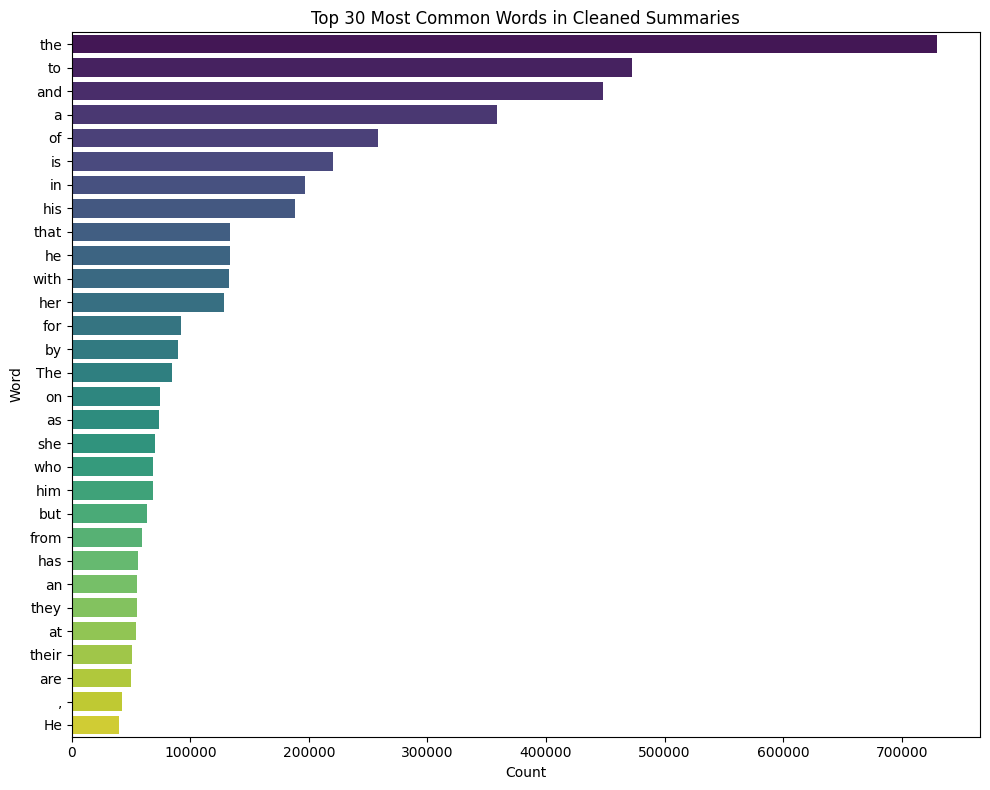

In [89]:
all_words = [word for summary in data['summary'] for word in summary.split()]
word_counts = Counter(all_words)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Create a DataFrame for visualization
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

# Plot the most common words
plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')
plt.title('Top 30 Most Common Words in Cleaned Summaries')
plt.tight_layout()
plt.show()

# Cell 16: Load or Preprocess and Save Summaries
- **Purpose**: Load preprocessed summaries from a file if available, otherwise preprocess summaries and save them.
- **Inputs**: `data` DataFrame, `os`, `logger`, `tqdm`, `clean_summary` function, `preprocessed_file` path.
- **Outputs**: `data` DataFrame with a new `clean_summary` column, optionally a saved `preprocessed_summaries.txt` file.
- **Operations**:
  - Defines the file path for storing preprocessed summaries (`preprocessed_file`).
  - Checks if `preprocessed_file` exists:
    - If it exists, reads the file and populates `data['clean_summary']` with the stored summaries.
    - If it does not exist, preprocesses each summary using `clean_summary`, saves the results to `preprocessed_file`, and logs the process.
  - Uses `tqdm` to display a progress bar during preprocessing.
  - Logs whether summaries were recovered or preprocessed and saved.
- **Note**: Optimizes workflow by reusing preprocessed data when available and ensures persistence of preprocessed summaries.

In [90]:

import os


# File path for saving the preprocessed summaries
preprocessed_file = './data/preprocessed_summaries.txt'

if os.path.exists(preprocessed_file):
    # Recover preprocessed summaries from the file
    logger.info("Recovering preprocessed summaries from file...")
    with open(preprocessed_file, 'r', encoding='utf-8') as f:
        data['clean_summary'] = [line.strip() for line in f.readlines()]
else:
    # Preprocess summaries and save to the file
    logger.info("Preprocessing summaries...")
    data['clean_summary'] = [clean_summary(text) for text in tqdm(data['summary'], desc="Preprocessing")]
    with open(preprocessed_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(data['clean_summary']))
    logger.info(f"Preprocessed summaries saved to {preprocessed_file}")


2025-05-12 15:41:34,497 - INFO - Recovering preprocessed summaries from file...


# Cell 17: Analyze and Visualize Most Common Words in Preprocessed Summaries
- **Purpose**: Extract and visualize the 30 most common words in the `clean_summary` column.
- **Inputs**: `data` DataFrame, `Counter`, `pd` (Pandas), `plt` (Matplotlib), `sns` (Seaborn).
- **Outputs**: `common_words_df` DataFrame, bar plot of the 30 most common words.
- **Operations**:
  - Splits each preprocessed summary (`clean_summary`) into words and flattens into a single list (`all_words`).
  - Counts word occurrences using `Counter`.
  - Extracts the 30 most common words with their counts.
  - Creates a `common_words_df` DataFrame with columns `Word` and `Count`.
  - Generates a horizontal bar plot using Seaborn, with word counts on the x-axis and words on the y-axis.
  - Customizes the plot with a title, Viridis palette, and tight layout.
- **Note**: Analyzes word frequency in preprocessed summaries to understand cleaned dataset content.

C:\Users\UmerFarooq\AppData\Local\Temp\ipykernel_19044\69842188.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')


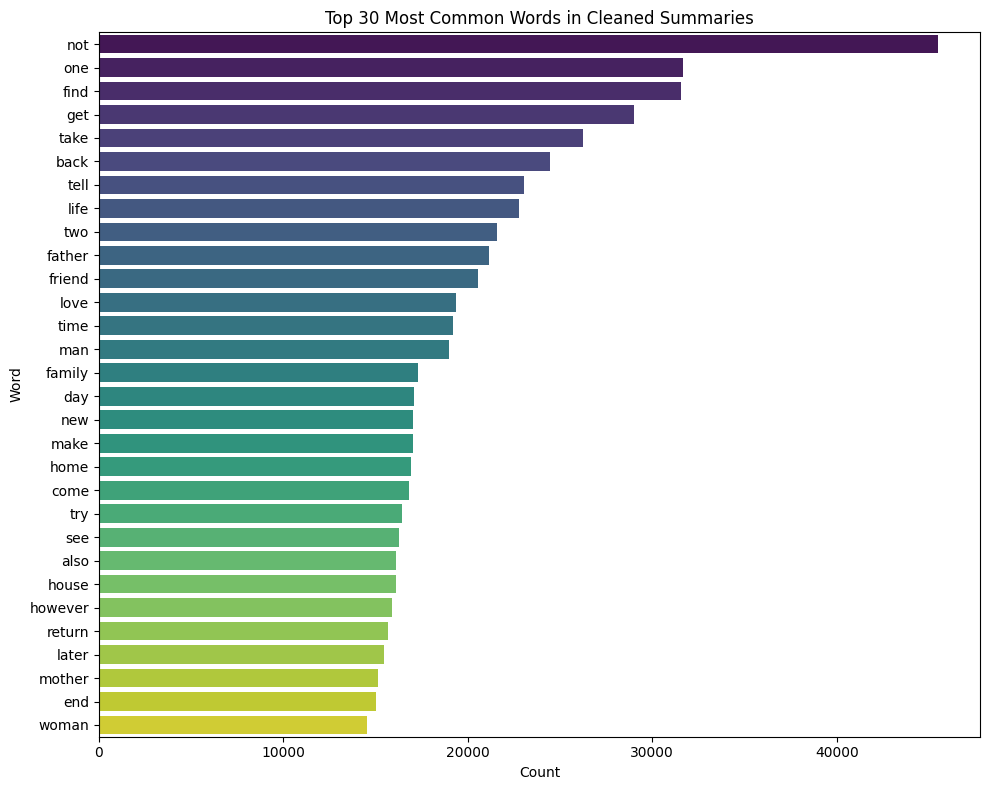

In [91]:

all_words = [word for summary in data['clean_summary'] for word in summary.split()]
word_counts = Counter(all_words)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Create a DataFrame for visualization
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

# Plot the most common words
plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')
plt.title('Top 30 Most Common Words in Cleaned Summaries')
plt.tight_layout()
plt.show()

# Cell 18: Final Data Cleaning and Genre Distribution Analysis
- **Purpose**: Clean data by removing invalid entries, create genre labels, and visualize genre distribution.
- **Inputs**: `data` DataFrame, `common_genres`, `genre_to_idx`, `logger`, `np` (NumPy), `pd` (Pandas), `plt` (Matplotlib), `sns` (Seaborn), `Counter`.
- **Outputs**: Updated `data` DataFrame, `y` genre label matrix, `genre_df` DataFrame, bar plot of genre distribution.
- **Operations**:
  - Prints missing values in `data` using `isnull().sum()`.
  - Filters out rows with empty `genres` lists.
  - Filters out rows where `clean_summary` has fewer than 10 words.
  - Logs the shape of the cleaned `data`.
  - Creates a binary genre label matrix `y` where rows are data entries and columns are genres (1 if genre is present, 0 otherwise).
  - Generates `genre_df` with genre counts, sorted by count in descending order.
  - Converts any tuple entries in `genre_df['Genre']` to strings.
  - Creates a horizontal bar plot of genre counts using Seaborn with a Viridis palette.
  - Customizes the plot with a title and tight layout.
- **Note**: Ensures data quality for modeling and provides insights into genre distribution.

Missing values in data: wiki_id          0
genres           0
summary          0
clean_summary    0
dtype: int64


2025-05-12 15:41:36,811 - INFO - Data after cleaning. Shape: (41596, 4)


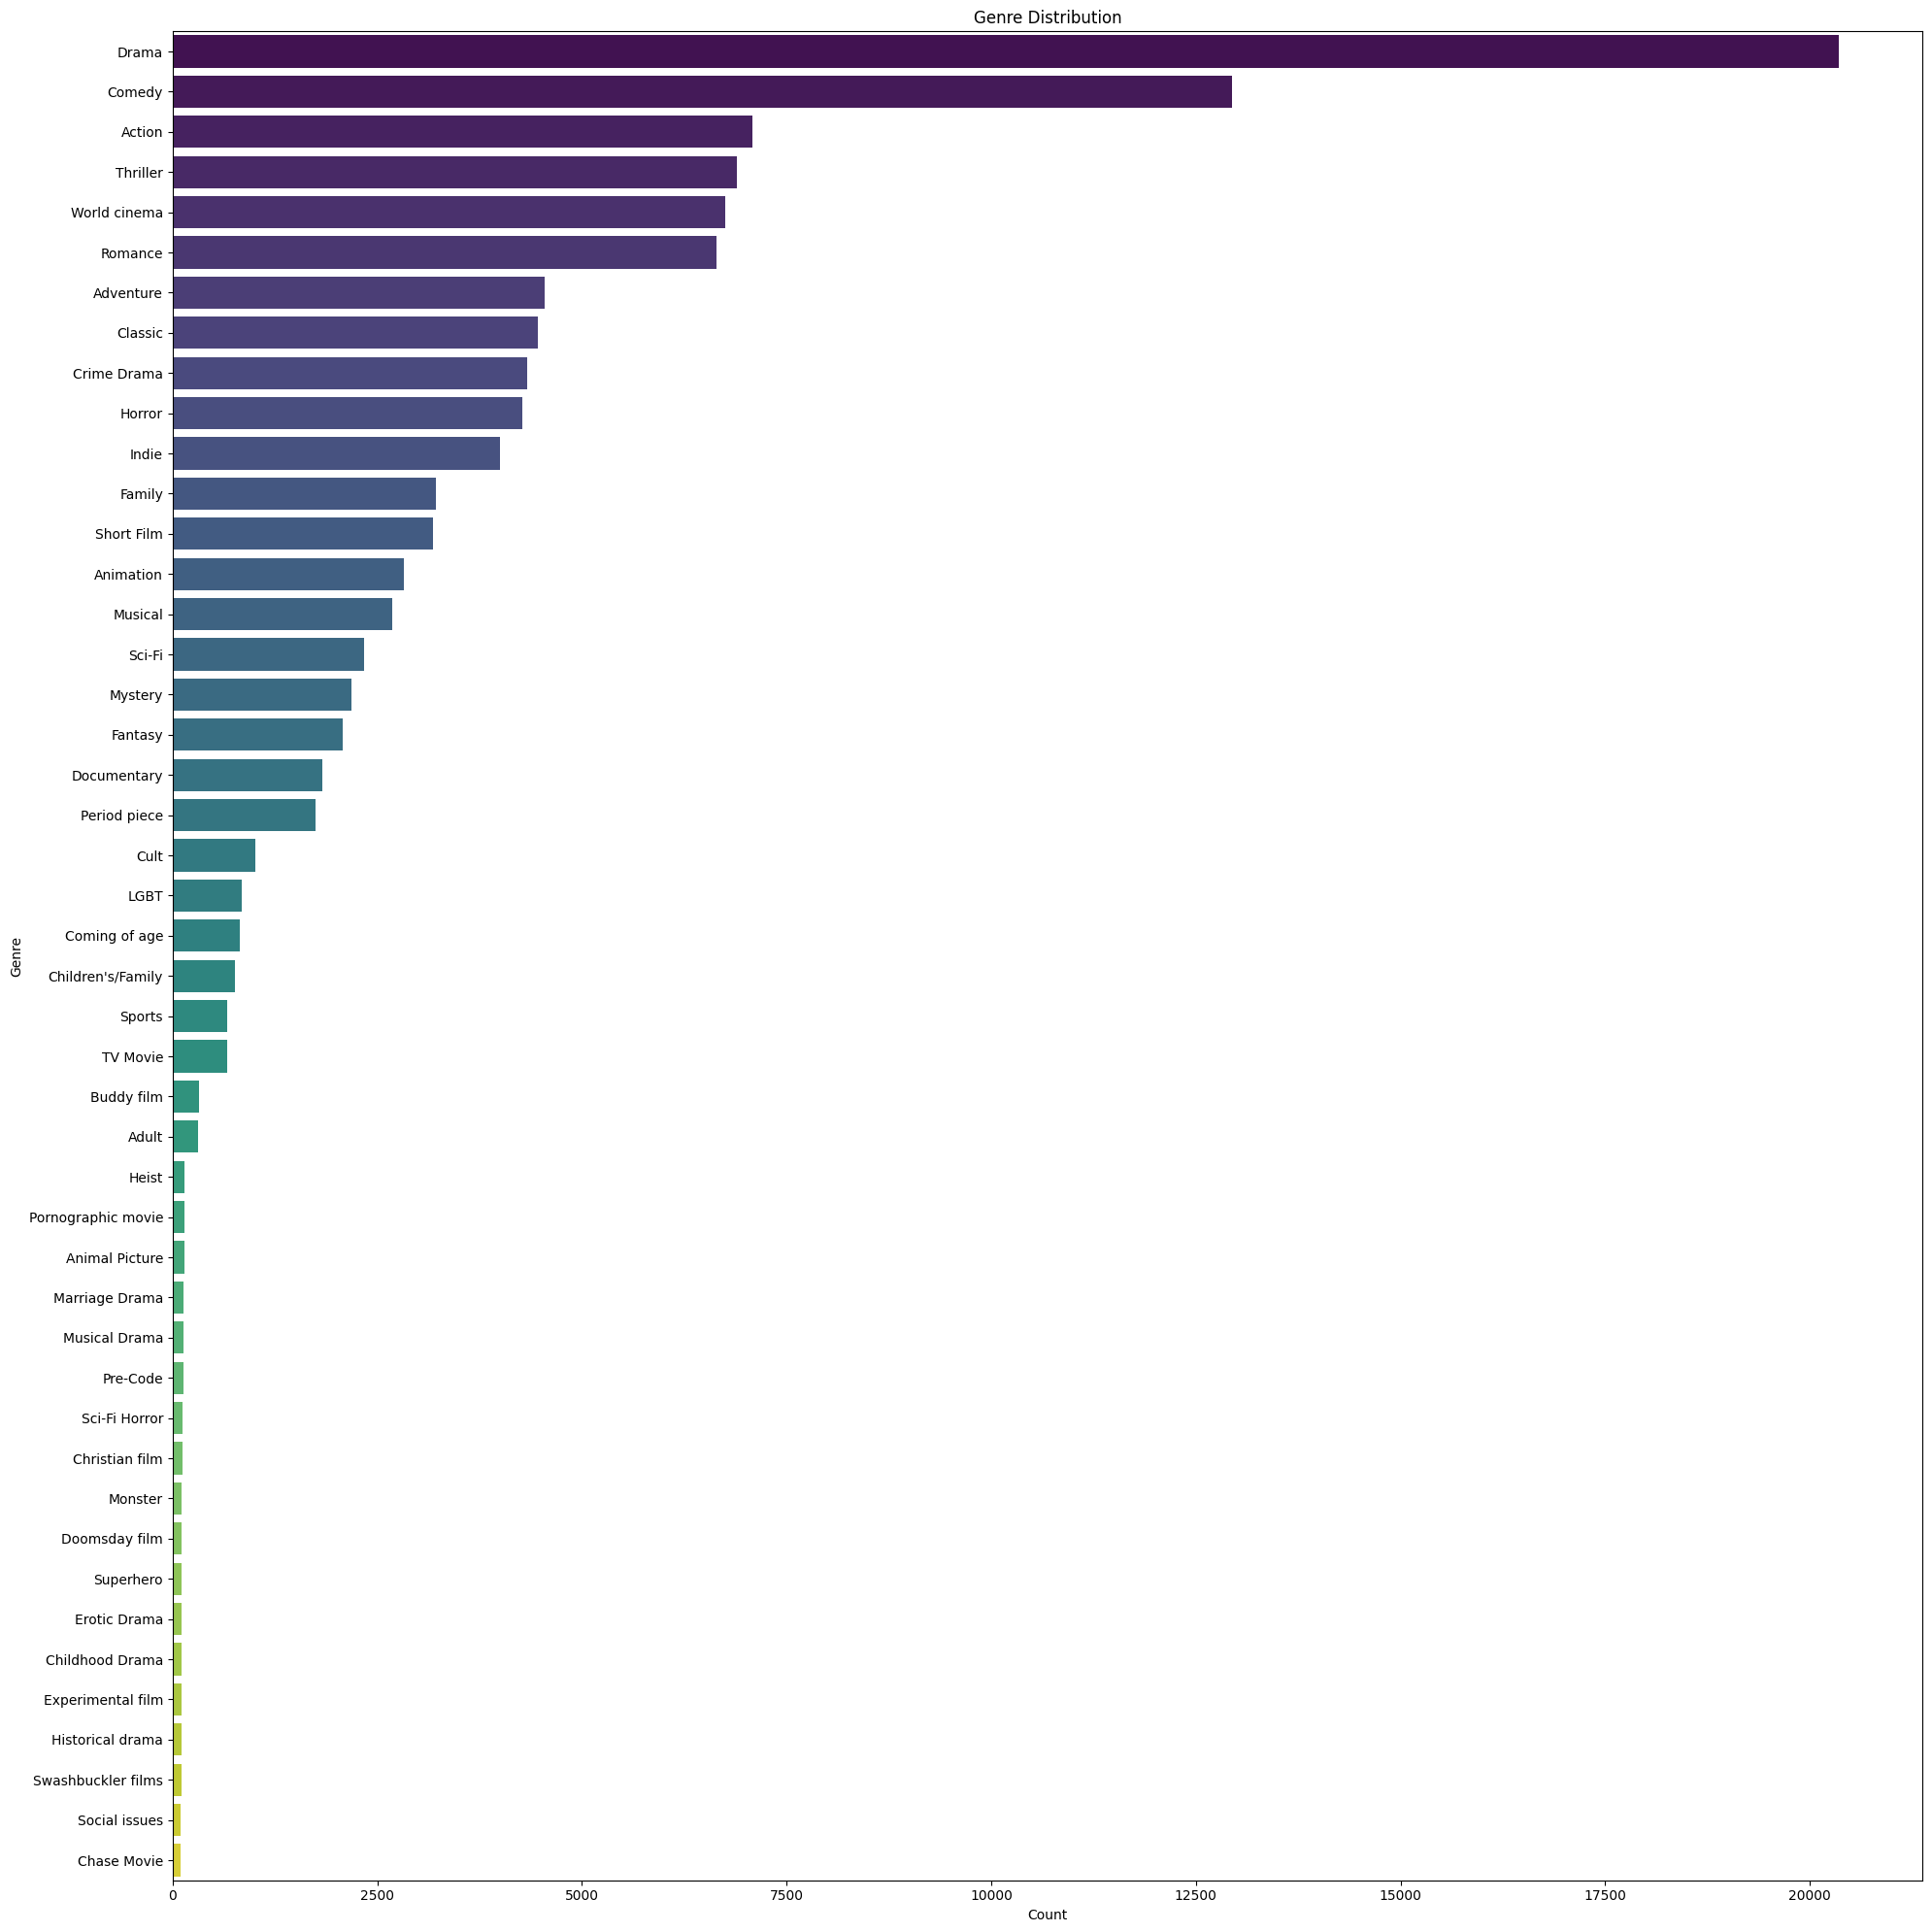

In [92]:
print(f"Missing values in data: {data.isnull().sum()}")
data = data[data['genres'].map(len) > 0]
data = data[data['clean_summary'].apply(lambda x: len(str(x).split()) >= 10)]
logger.info(f"Data after cleaning. Shape: {data.shape}")


# Create genre labels
all_genres = sorted(common_genres)
y = np.zeros((len(data), len(all_genres)))
for idx, genres in enumerate(data['genres']):
    for genre in genre_to_idx:
        if genre in genres:
            y[idx, genre_to_idx[genre]] = 1


genre_df = pd.DataFrame([(g, c) for g, c in Counter(genre for genres in data['genres'] for genre in genres).items()], 
                        columns=['Genre', 'Count']).sort_values('Count', ascending=False)

# Convert tuples in the 'Genre' column to strings
genre_df['Genre'] = genre_df['Genre'].apply(lambda x: ''.join(x) if isinstance(x, tuple) else x)

plt.figure(figsize=(20, 20))
sns.barplot(x='Count', y='Genre', data=genre_df,hue='Genre',legend=False, palette='viridis')
plt.title('Genre Distribution')
plt.tight_layout()
plt.show()

# Cell 19: Split Dataset
- **Purpose**: Split the dataset into training and test sets.
- **Inputs**: `data` DataFrame.
- **Outputs**: `X_train`, `X_test`, `y_train`, `y_test`.
- **Operations**:
  - Uses `train_test_split` with `test_size=0.2` (80-20 split).
  - Splits features (`clean_summary`) and labels (`genres`).
- **Note**: The 80-20 split is standard for model evaluation.

In [98]:
# Code for Cell 19: Split dataset

X_train, X_test, y_train, y_test = train_test_split(data[['clean_summary']], y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)
logger.info(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

2025-05-12 15:42:57,198 - INFO - Train: 29115, Val: 6241, Test: 6240


In [99]:
data.to_csv('./data/processed_data.csv', index=False)

# Cell 20: TF-IDF Vectorization
- **Purpose**: Convert cleaned summaries into TF-IDF features.
- **Inputs**: `X_train['clean_summary']`, `X_test['clean_summary']`.
- **Outputs**: `tfidf_train`, `tfidf_test`, `vectorizer`.
- **Operations**:
  - Initializes `TfidfVectorizer` with parameters (e.g., `max_features`, `ngram_range`).
  - Fits and transforms `X_train['clean_summary']` to `tfidf_train`.
  - Transforms `X_test['clean_summary']` to `tfidf_test`.
- **Note**: TF-IDF captures important terms for genre prediction.

In [94]:
# Code for Cell 20: TF-IDF vectorization

logger.info("Extracting features...")
vectorizer = TfidfVectorizer(
    max_features=5000,  # Reduced from 30000
    ngram_range=(1, 3),  # Reduced from (1, 3)
    min_df=5,           # Increased from 2
    max_df=0.7,         # Adjusted
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train['clean_summary'])
X_val_tfidf = vectorizer.transform(X_val['clean_summary'])
X_test_tfidf = vectorizer.transform(X_test['clean_summary'])

2025-05-12 15:41:37,663 - INFO - Extracting features...


# Cell 21: Extract Additional Features
- **Purpose**: Extract sentiment and text statistics features.
- **Inputs**: `X_train`, `X_test`.
- **Outputs**: `sentiment_train`, `sentiment_test`, `stats_train`, `stats_test`.
- **Operations**:
  - Uses `SentimentIntensityAnalyzer` to compute sentiment scores (negative, neutral, positive, compound).
  - Computes text statistics (word count, average word length).
  - Converts features to sparse matrices (`csr_matrix`).
- **Note**: Combines multiple feature types for richer input representation.

In [97]:
# Code for Cell 21: Extract additional features

def extract_sentiment_features(texts):
    return np.array([[sentiment_analyzer.polarity_scores(t or '')['neg'], 
                      sentiment_analyzer.polarity_scores(t or '')['neu'], 
                      sentiment_analyzer.polarity_scores(t or '')['pos'], 
                      sentiment_analyzer.polarity_scores(t or '')['compound']] 
                     for t in tqdm(texts, desc="Sentiment features")])


def extract_text_stats(texts):
    return np.array([[len(t.split()), 
                      sum(1 for w in t.split() if w.startswith('ADJ_')) / max(1, len(t.split())),
                      sum(1 for w in t.split() if w.startswith('V_')) / max(1, len(t.split())),
                      sum(1 for w in t.split() if w.startswith('ADV_')) / max(1, len(t.split())),
                      sum(len(w) for w in t.split()) / max(1, len(t.split()))] if t else [0, 0, 0, 0, 0]
                     for t in tqdm(texts, desc="Text stats")])

X_train_sentiment = extract_sentiment_features(X_train['clean_summary'])
X_val_sentiment = extract_sentiment_features(X_val['clean_summary'])
X_test_sentiment = extract_sentiment_features(X_test['clean_summary'])
X_train_stats = extract_text_stats(X_train['clean_summary'])
X_val_stats = extract_text_stats(X_val['clean_summary'])
X_test_stats = extract_text_stats(X_test['clean_summary'])


Sentiment features:   0%|          | 16/29115 [00:00<03:53, 124.70it/s]


KeyboardInterrupt: 

# Cell 22: Combine Features
- **Purpose**: Combine TF-IDF, sentiment, and text statistics features.
- **Inputs**: `tfidf_train`, `sentiment_train`, `stats_train`, `tfidf_test`, `sentiment_test`, `stats_test`.
- **Outputs**: `X_train_combined`, `X_test_combined`.
- **Operations**:
  - Uses `hstack` to concatenate sparse feature matrices.
- **Note**: Ensures all features are used in model training.

In [96]:
# Code for Cell 22: Combine features

X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_sentiment), csr_matrix(X_train_stats)])
X_val_combined = hstack([X_val_tfidf, csr_matrix(X_val_sentiment), csr_matrix(X_val_stats)])
X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_sentiment), csr_matrix(X_test_stats)])
logger.info(f"Feature shape: {X_train_combined.shape}")

NameError: name 'X_train_sentiment' is not defined

# Cell 23: Feature Selection
- **Purpose**: Select relevant features for each genre to reduce dimensionality.
- **Inputs**: `X_train_combined`, `y_train`.
- **Outputs**: `feature_selectors` dictionary.
- **Operations**:
  - Uses `SelectPercentile` with `chi2` to select top features for each genre.
  - Stores selectors in a dictionary keyed by genre.
- **Note**: Improves model efficiency and performance.

In [ ]:
# Code for Cell 23: Feature selection

feature_selectors = {genre: SelectPercentile(chi2, percentile=85).fit(X_train_tfidf, y_train[:, i]) 
                     for i, genre in enumerate(tqdm(all_genres, desc="Feature selection"))}
X_train_selected = {genre: feature_selectors[genre].transform(X_train_tfidf) for genre in all_genres}
X_val_selected = {genre: feature_selectors[genre].transform(X_val_tfidf) for genre in all_genres}
X_test_selected = {genre: feature_selectors[genre].transform(X_test_tfidf) for genre in all_genres}

Feature selection: 100%|██████████| 46/46 [00:01<00:00, 41.61it/s]


# Cell 24: Train Model
- **Purpose**: Train a multi-label classification model.
- **Inputs**: `X_train_combined`, `y_train`.
- **Outputs**: Trained `model` (`MultiOutputClassifier` with `LogisticRegression`).
- **Operations**:
  - Initializes `MultiOutputClassifier` with `LogisticRegression`.
  - Fits the model on selected features for each genre.
- **Note**: Logistic Regression is chosen for its simplicity and interpretability.

In [ ]:
# Code for Cell 24: Train model

preprocessed_data = {
    'data': data,
    'genre_counts': genre_counts,
    'genre_df': genre_df,
    'genre_mapping': genre_mapping,
    'genre_matrix': genre_matrix,
    'genre_to_idx': genre_to_idx,
    'all_genres': all_genres,
    'y': y,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'X_train_tfidf': X_train_tfidf,
    'X_val_tfidf': X_val_tfidf,
    'X_test_tfidf': X_test_tfidf,
    'X_train_combined': X_train_combined,
    'X_val_combined': X_val_combined,
    'X_test_combined': X_test_combined,
    'feature_selectors': feature_selectors,
    'custom_stopwords': custom_stopwords,
    'X_train_selected': X_train_selected,
    'X_val_selected': X_val_selected,
    'X_test_selected': X_test_selected
}

with open('./models/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

logger.info("Preprocessing outputs saved to './models/preprocessed_data.pkl'")

logger.info("Training Logistic Regression...")
model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=10, C=1.0, solver='lbfgs'), n_jobs=10)

# Combine features for all genres into a single array-like object
logger.info("Combining features for all genres...")
X_train_combined_features = hstack(list(X_train_selected.values()))  # Directly stack all features

# Fit the model
logger.info("Fitting the model...")
model.fit(X_train_combined_features, y_train)

def apply_genre_correlations(y_pred_proba, genres):
    adjusted = y_pred_proba.copy()
    for probs in tqdm(adjusted, desc="Applying correlations"):
        high_prob = [genres[i] for i, p in enumerate(probs) if p > 0.6]
        for g in high_prob:
            if g in genre_correlations.columns:
                for other_g, corr in genre_correlations[g].items():
                    if other_g in genre_to_idx and other_g != g and corr > 0.2:
                        probs[genre_to_idx[other_g]] = min(0.95, probs[genre_to_idx[other_g]] + corr * 0.2)
    return adjusted


2025-05-07 16:06:33,502 - INFO - Preprocessing outputs saved to './models/preprocessed_data.pkl'
2025-05-07 16:06:33,503 - INFO - Training Logistic Regression...
2025-05-07 16:06:33,504 - INFO - Combining features for all genres...
2025-05-07 16:06:35,287 - INFO - Fitting the model...


# Cell 25: Predict on Validation Set
- **Purpose**: Generate predictions on the validation set using trained model and apply genre correlations.
- **Inputs**: `X_val_selected` (validation features), `X_val_combined` (combined validation features), `model` (trained model), `all_genres`, `logger`, `np` (NumPy), `hstack` (SciPy), `apply_genre_correlations` function.
- **Outputs**: `y_val_pred_proba` (predicted probabilities for each genre on validation set).
- **Operations**:
  - Logs the start of prediction on the validation set.
  - Combines selected validation features into a single sparse matrix (`X_val_combined_features`) using `hstack`.
  - Initializes a prediction probability matrix (`y_val_pred_proba`) with zeros, shaped as (number of samples, number of genres).
  - Iterates through each estimator in the model to predict probabilities for each genre, storing results in `y_val_pred_proba`.
  - Applies genre correlations to the predicted probabilities using `apply_genre_correlations`.
- **Note**: Ensures consistent feature combination and leverages genre correlations to refine predictions.

In [ ]:
logger.info("Predicting on validation set...")
# First combine the selected features in the same way as during training
X_val_combined_features = hstack(list(X_val_selected.values()))

# Now make predictions using the combined features
y_val_pred_proba = np.zeros((X_val_combined.shape[0], len(all_genres)))
for i, est in enumerate(model.estimators_):
    y_val_pred_proba[:, i] = est.predict_proba(X_val_combined_features)[:, 1] if est else 0
    
y_val_pred_proba = apply_genre_correlations(y_val_pred_proba, all_genres)

2025-05-07 16:08:18,659 - INFO - Predicting on validation set...
Applying correlations: 100%|██████████| 6241/6241 [00:00<00:00, 15056.62it/s]


# Cell 26: Tune Thresholds and Predict on Test Set
- **Purpose**: Optimize classification thresholds for each genre and generate predictions on the test set.
- **Inputs**: `y_val` (validation labels), `y_val_pred_proba` (validation predicted probabilities), `X_test_selected` (test features), `X_test_combined` (combined test features), `model` (trained model), `all_genres`, `best_thresholds`, `logger`, `tqdm`, `np` (NumPy), `hstack` (SciPy), `f1_score` (scikit-learn), `apply_genre_correlations` function.
- **Outputs**: `best_thresholds` (optimized thresholds per genre), `y_test_pred_proba` (test predicted probabilities), `y_test_pred` (test binary predictions).
- **Operations**:
  - Iterates over each genre to tune thresholds:
    - Tests thresholds from 0.2 to 0.8 (step size 0.05) using `f1_score` on validation set.
    - Selects the threshold yielding the highest F1 score for each genre and stores in `best_thresholds`.
  - Logs the start of prediction on the test set.
  - Combines selected test features into a single sparse matrix (`X_test_combined_features`) using `hstack`.
  - Initializes a prediction probability matrix (`y_test_pred_proba`) with zeros, shaped as (number of test samples, number of genres).
  - Iterates through each estimator in the model to predict probabilities for each genre.
  - Applies genre correlations to `y_test_pred_proba` using `apply_genre_correlations`.
  - Generates binary predictions (`y_test_pred`) by applying the optimized thresholds to `y_test_pred_proba`.
- **Note**: Enhances prediction accuracy by tuning thresholds and refining predictions with genre correlations.

In [ ]:
best_thresholds = []
for i in tqdm(range(len(all_genres)), desc="Threshold tuning"):
    best_f1, best_thresh = 0, 0.5
    for thresh in np.arange(0.2, 0.8, 0.05):
        f1 = f1_score(y_val[:, i], (y_val_pred_proba[:, i] >= thresh).astype(int), average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh
    best_thresholds.append(best_thresh)


logger.info("Predicting on test set...")
# First combine the selected features
X_test_combined_features = hstack(list(X_test_selected.values()))

# Make predictions using combined features
y_test_pred_proba = np.zeros((X_test_combined.shape[0], len(all_genres)))
for i, est in enumerate(model.estimators_):
    y_test_pred_proba[:, i] = est.predict_proba(X_test_combined_features)[:, 1] if est else 0
    
y_test_pred_proba = apply_genre_correlations(y_test_pred_proba, all_genres)
y_test_pred = np.array([(y_test_pred_proba[:, i] >= t).astype(int) for i, t in enumerate(best_thresholds)]).T


Threshold tuning: 100%|██████████| 46/46 [00:00<00:00, 48.62it/s]
2025-05-07 16:13:36,309 - INFO - Predicting on test set...
Applying correlations: 100%|██████████| 6240/6240 [00:00<00:00, 16172.86it/s]


# Cell 27: Compute and Log Evaluation Metrics
- **Purpose**: Calculate and log overall and per-genre performance metrics for test set predictions.
- **Inputs**: `y_test` (test labels), `y_test_pred` (test binary predictions), `y_test_pred_proba` (test predicted probabilities), `all_genres`, `best_thresholds`, `logger`, `np` (NumPy), `precision_recall_fscore_support` (scikit-learn), `hamming_loss` (scikit-learn).
- **Outputs**: `class_report` (dictionary of per-genre metrics), logged metrics (micro, macro, accuracy, Hamming loss, hit rate, and per-genre metrics).
- **Operations**:
  - Logs the start of metric computation.
  - Computes micro-averaged precision, recall, and F1 scores across all genres.
  - Computes macro-averaged precision, recall, and F1 scores across all genres.
  - Calculates Hamming loss (fraction of incorrect labels) and hit rate (fraction of samples with at least one correct genre).
  - Computes exact-match accuracy (fraction of samples with all genres predicted correctly).
  - Logs micro, macro, accuracy, Hamming loss, and hit rate metrics.
  - For each genre with non-zero support in `y_test`:
    - Computes binary precision, recall, F1, and support.
    - Stores metrics and corresponding threshold in `class_report`.
    - Logs per-genre precision, recall, and F1 scores.
- **Note**: Provides comprehensive evaluation of model performance across multiple metrics and genres.

In [28]:

logger.info("Computing metrics...")
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='micro')
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')
hamming = hamming_loss(y_test, y_test_pred)
hit_rate = np.mean(np.sum(y_test * y_test_pred, axis=1) > 0)
accuracy = np.mean(np.all(y_test == y_test_pred, axis=1))
logger.info(f"Micro: Precision={micro_precision:.4f}, Recall={micro_recall:.4f}, F1={micro_f1:.4f}")
logger.info(f"Macro: Precision={macro_precision:.4f}, Recall={macro_recall:.4f}, F1={macro_f1:.4f}")
logger.info(f"Accuracy={accuracy:.4f}, Hamming Loss={hamming:.4f}, Hit Rate={hit_rate:.4f}")



# Per-genre metrics
class_report = {}
for i, genre in enumerate(all_genres):
    if y_test[:, i].sum() > 0:
        precision, recall, f1, support = precision_recall_fscore_support(y_test[:, i], y_test_pred[:, i], average='binary')
        class_report[genre] = {'precision': precision, 'recall': recall, 'f1-score': f1, 'support': int(support) if support is not None else 0, 'threshold': best_thresholds[i]}
        logger.info(f"{''.join(genre)}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")




2025-05-07 16:08:27,155 - INFO - Computing metrics...
2025-05-07 16:08:27,203 - INFO - Micro: Precision=0.4562, Recall=0.6271, F1=0.5282
2025-05-07 16:08:27,203 - INFO - Macro: Precision=0.3220, Recall=0.3994, F1=0.3485
2025-05-07 16:08:27,204 - INFO - Accuracy=0.0486, Hamming Loss=0.0654, Hit Rate=0.8873
2025-05-07 16:08:27,207 - INFO - Action: Precision=0.5427, Recall=0.6700, F1=0.5997
2025-05-07 16:08:27,209 - INFO - Adult: Precision=0.2034, Recall=0.2553, F1=0.2264
2025-05-07 16:08:27,212 - INFO - Adventure: Precision=0.4675, Recall=0.5657, F1=0.5120
2025-05-07 16:08:27,214 - INFO - Animal Picture: Precision=0.1860, Recall=0.4444, F1=0.2623
2025-05-07 16:08:27,216 - INFO - Animation: Precision=0.5078, Recall=0.6950, F1=0.5868
2025-05-07 16:08:27,218 - INFO - Buddy film: Precision=0.1250, Recall=0.0536, F1=0.0750
2025-05-07 16:08:27,220 - INFO - Chase Movie: Precision=0.1176, Recall=0.2000, F1=0.1481
2025-05-07 16:08:27,222 - INFO - Childhood Drama: Precision=0.0000, Recall=0.0000, 

# Cell 28: Visualize Per-Genre F1-Scores and Analyze Prediction Errors
- **Purpose**: Visualize F1-scores per genre and identify frequently missed genres and false positives.
- **Inputs**: `class_report` (per-genre metrics), `all_genres`, `y_test` (test labels), `y_test_pred` (test binary predictions), `logger`, `pd` (Pandas), `plt` (Matplotlib), `sns` (Seaborn), `Counter`, `np` (NumPy).
- **Outputs**: `genre_metrics_df` (DataFrame of per-genre metrics), bar plot of F1-scores, logged top missed genres and false positives.
- **Operations**:
  - Creates `genre_metrics_df` from `class_report` with columns `Genre`, `Precision`, `Recall`, and `F1`, sorted by F1-score in descending order.
  - Converts any tuple entries in `genre_metrics_df['Genre']` to strings.
  - Generates a horizontal bar plot of F1-scores per genre using Seaborn with a Viridis palette.
  - Customizes the plot with a title and tight layout.
  - Computes missed genres (true genres not predicted) and false positives (predicted genres not in true set) for each sample.
  - Uses `Counter` to tally missed genres and false positives across all samples.
  - Logs the top 5 missed genres and top 5 false positives.
- **Note**: Provides visual and statistical insights into model performance and common prediction errors.

C:\Users\UmerFarooq\AppData\Local\Temp\ipykernel_23700\1841584711.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1', y='Genre', data=genre_metrics_df, palette='viridis')


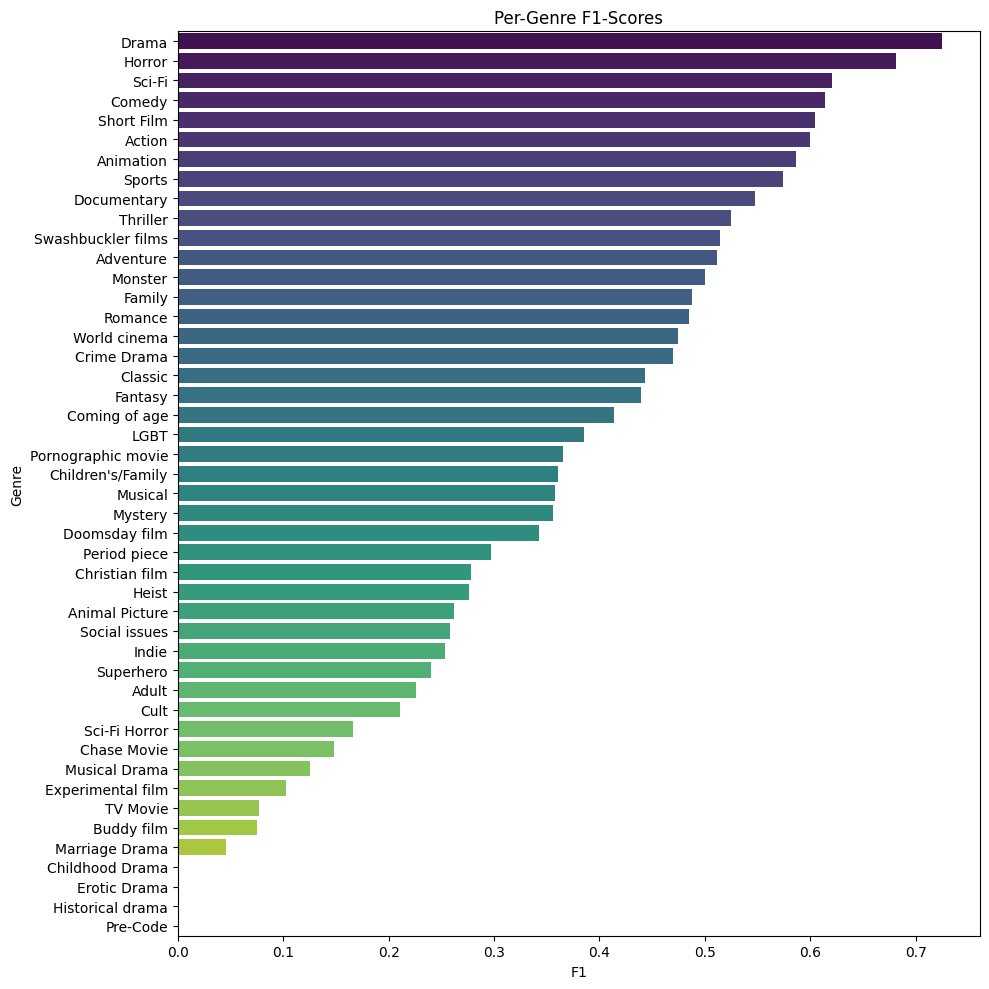

2025-05-07 16:17:50,525 - INFO - Top Missed Genres: [(('C', 'o', 'm', 'e', 'd', 'y'), 537), (('D', 'r', 'a', 'm', 'a'), 477), (('R', 'o', 'm', 'a', 'n', 'c', 'e'), 443), (('W', 'o', 'r', 'l', 'd', ' ', 'c', 'i', 'n', 'e', 'm', 'a'), 431), (('A', 'c', 't', 'i', 'o', 'n'), 360)]
2025-05-07 16:17:50,526 - INFO - Top False Positives: [(('I', 'n', 'd', 'i', 'e'), 1660), (('D', 'r', 'a', 'm', 'a'), 1452), (('C', 'o', 'm', 'e', 'd', 'y'), 1199), (('W', 'o', 'r', 'l', 'd', ' ', 'c', 'i', 'n', 'e', 'm', 'a'), 862), (('T', 'h', 'r', 'i', 'l', 'l', 'e', 'r'), 849)]


In [ ]:

genre_metrics_df = pd.DataFrame([(g, m['precision'], m['recall'], m['f1-score']) for g, m in class_report.items()],
                                columns=['Genre', 'Precision', 'Recall', 'F1']).sort_values('F1', ascending=False)

# Convert tuples in the 'Genre' column to strings
genre_metrics_df['Genre'] = genre_metrics_df['Genre'].apply(lambda x: ''.join(x) if isinstance(x, tuple) else x)

plt.figure(figsize=(10, 10))
sns.barplot(x='F1', y='Genre', data=genre_metrics_df, palette='viridis')
plt.title('Per-Genre F1-Scores')
plt.tight_layout()
plt.show()


missed_genres = Counter()
false_positives = Counter()
for true, pred in zip([set(all_genres[i] for i in np.where(t == 1)[0]) for t in y_test],
                      [set(all_genres[i] for i in np.where(p == 1)[0]) for p in y_test_pred]):
    missed_genres.update(true - pred)
    false_positives.update(pred - true)
logger.info(f"Top Missed Genres: {missed_genres.most_common(5)}")
logger.info(f"Top False Positives: {false_positives.most_common(5)}")

# Cell 29: Store Example Predictions
- **Purpose**: Identify and store examples of correct and incorrect predictions.
- **Inputs**: `y_test`, `y_test_pred`, `y_test_pred_proba`, `X_test`.
- **Outputs**: `examples` list with 10 prediction examples.
- **Operations**:
  - Computes Jaccard similarity to identify correct (perfect match) and incorrect (low overlap) predictions.
  - Stores five correct and five incorrect examples with summaries, true/predicted genres, probabilities, and accuracy.
- **Note**: Examples provide insight into model performance.

In [30]:
# Code for Cell 29: Store example predictions

def create_example(idx, y_test, y_pred, y_pred_proba, title, summary):
    true_g = [all_genres[i] for i in np.where(y_test[idx] == 1)[0]]
    pred_g = [all_genres[i] for i in np.where(y_pred[idx] == 1)[0]]
    jaccard = np.sum(np.logical_and(y_test[idx], y_pred[idx])) / max(1, np.sum(np.logical_or(y_test[idx], y_pred[idx])))
    return {
        'movie_name': title,
        'true_genres': true_g,
        'predicted_genres': pred_g,
        'genre_probabilities': {all_genres[i]: y_pred_proba[idx, i] for i in range(len(all_genres)) if y_pred_proba[idx, i] > 0.3},
        'summary': summary[:200] + '...' if len(summary) > 200 else summary,
        'accuracy': jaccard
    }


correct = [(i, np.sum(np.logical_and(y_test[i], y_test_pred[i])) / max(1, np.sum(np.logical_or(y_test[i], y_test_pred[i])))) 
           for i in range(len(y_test)) if np.all(y_test[i] == y_test_pred[i])]
incorrect = [(i, np.sum(np.logical_and(y_test[i], y_test_pred[i])) / max(1, np.sum(np.logical_or(y_test[i], y_test_pred[i])))) 
             for i in range(len(y_test)) if np.sum(np.logical_and(y_test[i], y_test_pred[i])) / max(1, np.sum(np.logical_or(y_test[i], y_test_pred[i]))) <= 0.5]
correct.sort(key=lambda x: -x[1])
incorrect.sort(key=lambda x: x[1])
examples = [create_example(i, y_test, y_test_pred, y_test_pred_proba, f"Movie {i+1}", X_test['clean_summary'].iloc[i]) 
            for i, _ in correct[:5] + incorrect[:5]]
logger.info(f"Stored {len(examples)} example predictions.")

2025-05-07 16:08:28,058 - INFO - Stored 10 example predictions.


# Cell 30: Save Model and Artifacts
- **Purpose**: Save the trained model and related objects for inference.
- **Inputs**: `model`, `vectorizer`, `feature_selectors`, `best_thresholds`.
- **Outputs**: Pickle files in `./models` (`genre_prediction_logistic_simplified.pkl`, `tfidf_vectorizer.pkl`, `feature_selectors.pkl`, `thresholds.pkl`).
- **Operations**:
  - Uses `pickle.dump` to save each object.
- **Note**: Enables model reuse in the application (`App.py`).

In [31]:
# Code for Cell 30: Save model and artifacts

# Save model and report
model_name = "genre_prediction_logistic_simplified"
with open(f'./models/{model_name}.pkl', 'wb') as f:
    pickle.dump(model, f)
with open(f'./models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open(f'./models/feature_selectors.pkl', 'wb') as f:
    pickle.dump(feature_selectors, f)
with open(f'./models/thresholds.pkl', 'wb') as f:
    pickle.dump(best_thresholds, f)

# Cell 31: Print Evaluation Report
- **Purpose**: Generate and display a detailed evaluation report.
- **Inputs**: Evaluation metrics, `examples`.
- **Outputs**: Printed report with metrics and example predictions.
- **Operations**:
  - Prints model details, micro/macro metrics, per-genre metrics, and 10 example predictions.
  - Includes summaries, true/predicted genres, probabilities, and accuracy for examples.
- **Note**: Provides a comprehensive summary of model performance.

In [32]:
# Code for Cell 31: Print evaluation report

print(f"=== EVALUATION REPORT ===\nDate: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
print("Model: Logistic Regression\nFeatures: TF-IDF + Sentiment + Text Stats\n")
print(f"Micro: Precision={micro_precision:.4f}, Recall={micro_recall:.4f}, F1={micro_f1:.4f}")
print(f"Macro: Precision={macro_precision:.4f}, Recall={macro_recall:.4f}, F1={macro_f1:.4f}")
print(f"Accuracy={accuracy:.4f}, Hamming Loss={hamming:.4f}, Hit Rate={hit_rate:.4f}\n")
print("Per-Genre Metrics:")
for genre, metrics in sorted(class_report.items(), key=lambda x: -x[1]['f1-score']):
    print(f"{''.join(genre)}:\n  Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}, Support={metrics['support']}")
print("\nExample Predictions:")
for i, ex in enumerate(examples):
    print(f"Example {i+1}: {ex['movie_name']}\nSummary: {ex['summary']}\nTrue: {', '.join(''.join(g) if isinstance(g, tuple) else g for g in ex['true_genres'])}\nPredicted: {', '.join(''.join(g) if isinstance(g, tuple) else g for g in ex['predicted_genres'])}")
    print("Probabilities:\n" + '\n'.join(f"  {g}: {p:.3f}" for g, p in sorted(ex['genre_probabilities'].items(), key=lambda x: -x[1])) + f"\nAccuracy: {ex['accuracy']:.3f}\n")


=== EVALUATION REPORT ===
Date: 2025-05-07 16:08:28

Model: Logistic Regression
Features: TF-IDF + Sentiment + Text Stats

Micro: Precision=0.4562, Recall=0.6271, F1=0.5282
Macro: Precision=0.3220, Recall=0.3994, F1=0.3485
Accuracy=0.0486, Hamming Loss=0.0654, Hit Rate=0.8873

Per-Genre Metrics:
Drama:
  Precision=0.6364, Recall=0.8419, F1=0.7249, Support=0
Horror:
  Precision=0.7016, Recall=0.6625, F1=0.6815, Support=0
Sci-Fi:
  Precision=0.5597, Recall=0.6968, F1=0.6208, Support=0
Comedy:
  Precision=0.5356, Recall=0.7203, F1=0.6144, Support=0
Short Film:
  Precision=0.5610, Recall=0.6545, F1=0.6041, Support=0
Action:
  Precision=0.5427, Recall=0.6700, F1=0.5997, Support=0
Animation:
  Precision=0.5078, Recall=0.6950, F1=0.5868, Support=0
Sports:
  Precision=0.4957, Recall=0.6824, F1=0.5743, Support=0
Documentary:
  Precision=0.5286, Recall=0.5688, F1=0.5480, Support=0
Thriller:
  Precision=0.4396, Recall=0.6523, F1=0.5252, Support=0
Swashbuckler films:
  Precision=0.6000, Recall=0.4

# Cell 32: Print Unique Genres
- **Purpose**: Display all unique genres in the dataset.
- **Inputs**: `data` DataFrame.
- **Outputs**: Printed list of unique genres.
- **Operations**:
  - Converts genre tuples to strings.
  - Extracts unique genres using a set comprehension.
  - Prints sorted genres.
- **Note**: Helps verify the genre set used in classification.

In [41]:
# Code for Cell 32: Print unique genres

# print all unique genres
# Convert the tuples to strings
data['genres'] = data['genres'].apply(lambda genres: [''.join(g) for g in genres])

# When displaying unique genres, also convert them to strings
unique_genres = set(''.join(g) for genres in data['genres'] for g in genres)
print("Unique genres:", sorted(unique_genres))
print(f"Total unique genres: {len(unique_genres)}")

Unique genres: ['Action', 'Adult', 'Adventure', 'Animal Picture', 'Animation', 'Buddy film', 'Chase Movie', 'Childhood Drama', "Children's/Family", 'Christian film', 'Classic', 'Comedy', 'Coming of age', 'Crime Drama', 'Cult', 'Documentary', 'Doomsday film', 'Drama', 'Erotic Drama', 'Experimental film', 'Family', 'Fantasy', 'Heist', 'Historical drama', 'Horror', 'Indie', 'LGBT', 'Marriage Drama', 'Monster', 'Musical', 'Musical Drama', 'Mystery', 'Period piece', 'Pornographic movie', 'Pre-Code', 'Romance', 'Sci-Fi', 'Sci-Fi Horror', 'Short Film', 'Social issues', 'Sports', 'Superhero', 'Swashbuckler films', 'TV Movie', 'Thriller', 'World cinema']
Total unique genres: 46


# Cell 33: Generate Confusion Matrices
- **Purpose**: Compute and log confusion matrices for each genre and overall.
- **Inputs**: `y_test`, `y_test_pred`, `all_genres`.
- **Outputs**: `confusion_matrices` dictionary, `overall_cm`.
- **Operations**:
  - Uses `confusion_matrix` to compute matrices for each genre.
  - Aggregates matrices into an overall confusion matrix.
  - Logs matrices using `logger`.
- **Note**: Provides detailed insights into classification performance per genre.

In [34]:
# Code for Cell 33: Generate confusion matrices

from sklearn.metrics import confusion_matrix

# Generate confusion matrices for each genre
confusion_matrices = {}
overall_cm = np.zeros((2, 2), dtype=int)  # Initialize overall confusion matrix

for i, genre in enumerate(all_genres):
    cm = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    confusion_matrices[genre] = cm
    overall_cm += cm  # Add to overall confusion matrix
    logger.info(f"Confusion Matrix for {''.join(genre)}:\n{cm}")

# Log the overall confusion matrix
logger.info(f"Overall Confusion Matrix:\n{overall_cm}")

2025-05-07 16:08:28,278 - INFO - Confusion Matrix for Action:
[[4533  616]
 [ 360  731]]
2025-05-07 16:08:28,282 - INFO - Confusion Matrix for Adult:
[[6146   47]
 [  35   12]]
2025-05-07 16:08:28,286 - INFO - Confusion Matrix for Adventure:
[[5089  451]
 [ 304  396]]
2025-05-07 16:08:28,289 - INFO - Confusion Matrix for Animal Picture:
[[6187   35]
 [  10    8]]
2025-05-07 16:08:28,293 - INFO - Confusion Matrix for Animation:
[[5532  285]
 [ 129  294]]
2025-05-07 16:08:28,297 - INFO - Confusion Matrix for Buddy film:
[[6163   21]
 [  53    3]]
2025-05-07 16:08:28,301 - INFO - Confusion Matrix for Chase Movie:
[[6215   15]
 [   8    2]]
2025-05-07 16:08:28,305 - INFO - Confusion Matrix for Childhood Drama:
[[6218    4]
 [  18    0]]
2025-05-07 16:08:28,309 - INFO - Confusion Matrix for Children's/Family:
[[6022   91]
 [  79   48]]
2025-05-07 16:08:28,313 - INFO - Confusion Matrix for Christian film:
[[6209    9]
 [  17    5]]
2025-05-07 16:08:28,317 - INFO - Confusion Matrix for Classi